In [181]:
import numpy as np
import pandas as pd
from gensim import corpora, models, similarities
from gensim.models import word2vec

from sklearn import datasets
from sklearn import linear_model
from sklearn import svm
from sklearn import preprocessing
import random
import pickle
import time

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
base_path = "/home/R2016hwang/research/"
model_name_en = base_path + "word2vec/model_sg_en_wzh.w2v"
model_name_jp = base_path + "word2vec/model_sg_jp_wzh.w2v"
model_name_zh = base_path + "word2vec/model_sg_zh_wzh.w2v"

model_en = word2vec.Word2Vec.load(model_name_en)
model_jp = word2vec.Word2Vec.load(model_name_jp)
model_zh = word2vec.Word2Vec.load(model_name_zh)

trans_jp_en = np.load("word2vec/jp_en.npy")
trans_zh_en = np.load("word2vec/zh_en.npy")

datapath = base_path + "data_prepare/cleaned_jp_en_zh.csv"

2018-05-08 00:01:56,430 : INFO : loading Word2Vec object from /home/R2016hwang/research/word2vec/model_sg_en_wzh.w2v
2018-05-08 00:01:57,040 : INFO : loading wv recursively from /home/R2016hwang/research/word2vec/model_sg_en_wzh.w2v.wv.* with mmap=None
2018-05-08 00:01:57,041 : INFO : setting ignored attribute syn0norm to None
2018-05-08 00:01:57,043 : INFO : setting ignored attribute cum_table to None
2018-05-08 00:01:57,044 : INFO : loaded /home/R2016hwang/research/word2vec/model_sg_en_wzh.w2v
2018-05-08 00:01:57,176 : INFO : loading Word2Vec object from /home/R2016hwang/research/word2vec/model_sg_jp_wzh.w2v
2018-05-08 00:01:57,509 : INFO : loading wv recursively from /home/R2016hwang/research/word2vec/model_sg_jp_wzh.w2v.wv.* with mmap=None
2018-05-08 00:01:57,510 : INFO : setting ignored attribute syn0norm to None
2018-05-08 00:01:57,511 : INFO : setting ignored attribute cum_table to None
2018-05-08 00:01:57,512 : INFO : loaded /home/R2016hwang/research/word2vec/model_sg_jp_wzh.w2

In [3]:
maxlen = 20 # Default: 0 -> infinite
epoch = 10
dim_lstm = 100
dim_1 = 800
# dim_2 = 100
# dim_3 = 50
dropout_rate = 0.0
bias_y = 0
loss_function = "mse"
mode = "reg" # reg, binary
rnn_type = "bi-lstm" # lstm, bi-lstm
bi_lstm_mode = "sum" #concat, sum
print("maxlen", maxlen, "epoch", epoch, "dim_lstm", dim_lstm)
print("dim_Dense", dim_1)
print("dropout_rate", dropout_rate, ", LSTM type:", rnn_type, bi_lstm_mode)
p_activation = ["relu", "relu", "relu"]
print("Activation function:", p_activation)
print("bias of y:", bias_y)
print("loss_function:", loss_function)
start = 0
step = 10
print("start:", start, "end:", )
print("------------------------------")
random.seed(1234)

maxlen 20 epoch 10 dim_lstm 100
dim_Dense 800
dropout_rate 0.0 , LSTM type: bi-lstm sum
Activation function: ['relu', 'relu', 'relu']
bias of y: 0
loss_function: mse
start: 0 end:
------------------------------


In [194]:
torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 1          # 训练整批数据多少次
BATCH_SIZE = 100
TIME_STEP = 20      # rnn 时间步数 / 图片高度
INPUT_SIZE = 100     # rnn 每步输入值 / 图片每行像素
HIDDEN_SIZE = 100
BIDIRECTION = False
LR = 0.01           # learning rate
DROP_OUT = 0.0

In [206]:
class LaLSTM(nn.Module):
    def __init__(self, batch_size=BATCH_SIZE, time_step=TIME_STEP, hidden_size=HIDDEN_SIZE, input_size=INPUT_SIZE, dropout_p=DROP_OUT, bidirection=False, attention=False):
        super(LaLSTM, self).__init__()
        self.attention = attention
        self.lstm_left = nn.LSTM(     # LSTM 效果要比 nn.RNN() 好多了
            input_size=input_size,      # 图片每行的数据像素点
            hidden_size=hidden_size,     # rnn hidden unit
            num_layers=1,       # 有几层 RNN layers
            batch_first=True,   # input & output 会是以 batch size 为第一维度的特征集 e.g. (batch, time_step, input_size)
            bidirectional=bidirection,
        )
        
        self.lstm_right = nn.LSTM(     # LSTM 效果要比 nn.RNN() 好多了
            input_size=input_size,      # 图片每行的数据像素点
            hidden_size=hidden_size,     # rnn hidden unit
            num_layers=1,       # 有几层 RNN layers
            batch_first=True,   # input & output 会是以 batch size 为第一维度的特征集 e.g. (batch, time_step, input_size)
            bidirectional=bidirection,
        )
        
        if bidirection:
            print("bidirection")
            self.full_connect = torch.nn.Sequential(
                                                #torch.nn.Linear(hidden_size*2, hidden_size),
                                                #torch.nn.ReLU(),
                                                torch.nn.Linear(hidden_size*4, 1),
                                                torch.nn.ReLU()
                                                )
            self.attn_left = nn.Linear(4*hidden_size, hidden_size, bias=False)
            #self.attn_apply_left = nn.Linear(self.)
            self.attn_right = nn.Linear(4*hidden_size, hidden_size, bias=False)
        else:
            self.attn_left = nn.Linear(2*hidden_size, hidden_size, bias=False)
            #self.attn_apply_left = nn.Linear(self.)
            self.attn_right = nn.Linear(2*hidden_size, hidden_size, bias=False)

            self.full_connect = torch.nn.Sequential(
                                                    #torch.nn.Linear(hidden_size*2, hidden_size),
                                                    #torch.nn.ReLU(),
                                                    torch.nn.Linear(hidden_size*2, 1),
                                                    torch.nn.ReLU()
                                                    )

        self.dropout = nn.Dropout(dropout_p)
        #self.gru = nn.GRU(self.hidden_size, self.hidden_size)

        
    def forward(self, x_left, x_right):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)   LSTM 有两个 hidden states, h_n 是分线, h_c 是主线
        # h_c shape (n_layers, batch, hidden_size)
        # batch_first = True : (batch, time_step, input_size)
        
        ##left_out, (h_n_left, h_c_left) = self.lstm_left(x, None)   # None 表示 hidden state 会用全0的 state
        ##right_out, (h_n_right, h_c_right) = self.lstm_right(x, None)

        # 选取最后一个时间点的 r_out 输出
        # 这里 r_out[:, -1, :] 的值也是 h_n 的值
        ##out = self.out(r_out[:, -1, :])
        ##return out
    
        left_out, left_hidden = self.lstm_left(x_left)   # None 表示 hidden state 会用全0的 state
        right_out, right_hidden = self.lstm_right(x_right)
        #r_out_reshaped = r_out.view(-1, HIDDEN_SIZE) # to 2D data
        #outs = self.linear_layer(r_out_reshaped)
        #left_out = left_out.view(-1, TIME_STEP, INPUT_SIZE)  # to 3D data
        #right_out = right_out.view(-1, TIME_STEP, INPUT_SIZE)  # to 3D data
        
        #h_state_left = (h_n_left, h_c_left)
        #h_state_right = (h_n_right, h_c_right)
        
        # attention = h_left dot h_right.T
        #(batch, h_left, h_right)
        attn_matrix_left = torch.bmm(left_out,torch.transpose(right_out,1,2))
        #(batch, h_right, h_left)
        attn_matrix_right = torch.bmm(right_out,torch.transpose(left_out,1,2))
        left_at = F.softmax(attn_matrix_left,2)
        right_at = F.softmax(attn_matrix_right,2)
        left_ct = torch.bmm(left_at,right_out)
        right_ct = torch.bmm(right_at,left_out)
        #take only last attention for results without feed_in
        left_hn = left_out[:, -1, :].squeeze(1)
        right_hn = right_out[:, -1, :].squeeze(1)
        left_cn = left_ct[:, -1, :].squeeze(1)
        right_cn = right_ct[:, -1, :].squeeze(1)
        
        left_new_hn = F.tanh(self.attn_left(torch.cat((left_hn,left_cn),1)))
        right_new_hn = F.tanh(self.attn_right(torch.cat((right_hn,right_cn),1)))
        
        if self.attention:
            self.out = self.full_connect(torch.cat((left_new_hn,right_new_hn),1))
        else:
            self.out = self.full_connect(torch.cat((left_hn,right_hn),1))
        
        return self.out

lalstm = LaLSTM()
print(lalstm)

LaLSTM(
  (lstm_left): LSTM(100, 100, batch_first=True)
  (lstm_right): LSTM(100, 100, batch_first=True)
  (attn_left): Linear(in_features=200, out_features=100, bias=False)
  (attn_right): Linear(in_features=200, out_features=100, bias=False)
  (full_connect): Sequential(
    (0): Linear(in_features=200, out_features=1, bias=True)
    (1): ReLU()
  )
  (dropout): Dropout(p=0.0)
)


In [17]:
def prepare_train(dir_en_jp, second_language="jp", start=None, end=None):

    # df_en_mapping = pd.read_csv(dir_en)
    # df_jp_mapping = pd.read_csv(dir_jp)
    second_article = second_language+"_article"
    
    df_en_jp = pd.read_csv(dir_en_jp,
                              names=["HEADLINE_ALERT_TEXT_x","HEADLINE_ALERT_TEXT_y", "HEADLINE_ALERT_TEXT","jp_article","en_article","zh_article"],
                              header=0)
    df_en_mapping = df_en_jp[["en_article"]].iloc[start:end]
    df_jp_mapping = df_en_jp[[second_article]].iloc[start:end]

    print("Reading English Data:", len(df_en_mapping))
    print("Reading "+second_language+" Data:", len(df_jp_mapping))

    sample_size = len(df_en_mapping)

    assert len(df_en_mapping) == len(df_jp_mapping)

    # Convert mapping to list type and then concat to the a list
    print("Merging the English and Japanes news dataframe...")
    df_train_1 = pd.concat([df_en_mapping, df_jp_mapping], axis = 1)
    df_train_1['similarity'] = pd.Series(np.ones(sample_size,)*5)
    df_train_1['dis_similarity'] = pd.Series(np.ones(sample_size,)*1)

    # Remove null line
    print("Drop the null line...")
    # df_train_1 = df_train_1.dropna(subset=['en_article'])
    df_train_1 = df_train_1[df_train_1['en_article'] != '<NULL>']

    # Expand the training data
    en_article_wrong = df_train_1.en_article.iloc[random.sample(range(len(df_train_1)),len(df_train_1))]
    en_article_wrong.index = df_train_1.index
    print((en_article_wrong == df_train_1.en_article).value_counts())
    df_train_1['en_article_wrong'] = en_article_wrong

    # Convert dateframe to list
    train_1 = df_train_1[['en_article',second_article,'similarity']].values.tolist()
    train_2 = df_train_1[['en_article_wrong',second_article,'dis_similarity']].values.tolist()

    return train_1, train_2, df_train_1

In [138]:
def padding(sequence, maxlen=maxlen, padding_value=0.0):
    np_sequance = np.array(sequence)
    #print(np_sequance.shape)
    if np_sequance.shape[0] == 0:
        #return float('nan')
        print("长度为零")
        #return float('nan')
        return np.zeros((maxlen, INPUT_SIZE))
    if np_sequance.shape[0] < maxlen:
        z = np.zeros((maxlen, INPUT_SIZE))
    #    print(z.shape)
        z[:np_sequance.shape[0], :np_sequance.shape[1]] = np_sequance
    else:
        z = np_sequance[:maxlen, :]
    return z


In [115]:
def find_ranking_batch(projection1, projection2, dlmodel, batch=10):
    sim_results = []
    rank_results = []
    sample_length = len(projection2)

    # Iterate each of the ariticle from projection1 (999) as proj1
    # Calculate the simialrity of proj1 with all ariticles in projection2 (999)
    # for i, proj1 in enumerate(projection1):
    for i in range(0, sample_length, batch):
        print("Find answer for doc.", i, i+batch)
        proj1 = projection1[i:i+batch]

        proj1_tile = np.repeat(proj1, sample_length, axis=0)
        proj2_tile = np.tile(projection2, (batch,1,1))
        print(proj1_tile.shape)
        print(proj2_tile.shape)

        # For each batch, we should tile each of the element
        sim = dlmodel.predict([proj1_tile, proj2_tile])[:,0]
        for j in range(0, sample_length, batch):
            rank = pd.Series(sim[j:j+sample_length]).rank(ascending = False)[i]
            sim_results.append(sim)
            rank_results.append(rank)

    # sim_results contains 999*999 similairty matrix
    return sim_results, rank_results

def find_ranking(projection1, projection2, dlmodel):
    sim_results = []
    rank_results = []

    # Iterate each of the ariticle from projection1 (999) as proj1
    # Calculate the simialrity of proj1 with all ariticles in projection2 (999)
    for i, proj1 in enumerate(projection1):
        print("Find answer for doc.", i)
        proj1_tile = np.tile(proj1, (len(projection2), 1, 1))
        sim = dlmodel.predict([proj1_tile, projection2])[:,0]
        rank = pd.Series(sim).rank(ascending = False)[i]
        sim_results.append(sim)
        rank_results.append(rank)

    # sim_results contains 999*999 similairty matrix
    return sim_results, rank_results


In [116]:
def find_top(rank_results, top):
    s = pd.Series(rank_results)
    n_top = (s <= top).sum()
    return n_top


def average_docment(document_embedding):
    return np.average(document_embedding, axis=0)

def sum_docment(document_embedding):
    return np.sum(document_embedding, axis=0)

In [129]:
def doc2embed(doc,model,translation_matrix=None):
    # r = [model_en[token] for token in doc.split()]
    r = []
    r_failed = []

    
    for token in str(doc).split(' '):
        if token in model:
            if type(translation_matrix) != type(None) :
                #print("translation_matrix ",translation_matrix.shape)
                #print(np.array(model[token]).shape)
                r.append(np.array(model[token]).dot(translation_matrix))
            else:
                r.append(model[token])
        else:
            r_failed.append(token)

    # if len(r_failed) != 0:
    #     print " ".join(r_failed)
    #print("Failed Number",len(r_failed))
    return r


In [118]:
pairs_correct_enjp, pairs_wrong_enjp, df_pairs_enjp = prepare_train(datapath,second_language='jp')

Reading English Data: 81283
Reading jp Data: 81283
Merging the English and Japanes news dataframe...
Drop the null line...
False    80993
True       290
Name: en_article, dtype: int64


In [119]:
df_pairs_enjp

,en_article,jp_article,similarity,dis_similarity,en_article_wrong
0,china slow mid-term prospect bright-fitch,中国 経済成長 やや 減速 中期 見通し 良好 フィッチ,5.0,1.0,factbox-electoral vote tally US election
1,US stock open low ahead greenspan remark,米国 株式市場 序盤 小幅安 グリーンスパン 議長 証言 控え,5.0,1.0,hk share slip open financials weigh
2,US 3-month bill high rate pct,表 米 落札 結果 最高 落札 金利 3か月 6か月,5.0,1.0,analysis-long bumpy road ahead obama financial...
3,US 3-month bill high rate pct,表 米 落札 結果 最高 落札 金利 3か月 6か月,5.0,1.0,us treasury outlook-headline risk
4,US 3-month bill high rate pct,表 米 落札 結果 最高 落札 金利 3か月 6か月,5.0,1.0,instant view 7- fed refrain cut stimulus
5,US stock open slightly high ahead fed,米国 株式市場 序盤 小 反発 FOMC 結果 見守る,5.0,1.0,highlights-bernanke testimony fed monetary p...
6,rpt-US stock open slightly high ahead fed,米国 株式市場 序盤 小 反発 FOMC 結果 見守る,5.0,1.0,coeure say ecb keep monetary policy accommodative
7,blair say worry oil want low price,原油価格 問題 議題 なる 可能性 英 首相,5.0,1.0,wrapup 2-china order state firm explore potash...
8,s korea fin min see gdp 4-5 pct report,今年 下期 韓国 GDP 成長率 見通し 財政 経済,5.0,1.0,bmw post may sale record volumes up pct
9,s korea fin min see gdp 4-5 pct report,再送 今年 下期 韓国 GDP 成長率 見通し 財政 経済,5.0,1.0,stocks-tech lift wall st s p mark bad week nov...


In [120]:
pairs_correct_enzh, pairs_wrong_enzh, df_pairs_enzh = prepare_train(datapath,second_language='zh')

Reading English Data: 81283
Reading zh Data: 81283
Merging the English and Japanes news dataframe...
Drop the null line...
False    80963
True       320
Name: en_article, dtype: int64


In [121]:
df_pairs_enzh

,en_article,zh_article,similarity,dis_similarity,en_article_wrong
0,china slow mid-term prospect bright-fitch,重發 中國 經濟 惠譽 預計 GDP 增速 今明兩年 放緩 至 與 但 中期 前景 看好,5.0,1.0,us treasury outlook-keep your seatbelt fasten
1,US stock open low ahead greenspan remark,美國股市 微幅 開 低 市場 等待 格老 證詞 演說,5.0,1.0,breakingviews-russia would pay steep pricEUkra...
2,US 3-month bill high rate pct,美國 債市 三個 月期 國庫券 標售 得標 利率 為 投標 倍數 為,5.0,1.0,factbox-electoral vote tally US election
3,US 3-month bill high rate pct,美國 債市 三個 月期 國庫券 標售 得標 利率 為 投標 倍數 為,5.0,1.0,factbox-electoral vote tally US election
4,US 3-month bill high rate pct,美國 債市 三個 月期 國庫券 標售 得標 利率 為 投標 倍數 為,5.0,1.0,factbox-electoral vote tally u election
5,US stock open slightly high ahead fed,美國股市 開盤 微幅 走高 市場 等待 FED 利率 聲明,5.0,1.0,canada name edc head poloz new bank canada gov...
6,rpt-US stock open slightly high ahead fed,美國股市 開盤 微幅 走高 市場 等待 FED 利率 聲明,5.0,1.0,hk track weak global market coal stock gain
7,blair say worry oil want low price,國際 油市 布萊爾 稱 G 領導人 擔憂 油價 希望 各國 為 抑制 油價 作出努力,5.0,1.0,white house adviser summer leave soon -nbc
8,s korea fin min see gdp 4-5 pct report,韓國 經濟 財長 預期 下半年 GDP 較 上年 同期 成長 報導,5.0,1.0,wrapup budget deficit soar record trln
9,s korea fin min see gdp 4-5 pct report,韓國 經濟 財長 預期 下半年 GDP 較 上年 同期 成長 報導,5.0,1.0,euro govt-bunds rally market trim global rate ...


In [140]:
print("Using the new test data to evaluate.......")
df_pairs_evaluate = df_pairs_enjp.iloc[50000:55000:5]

df_pairs_evaluate['word2vec_en'] = df_pairs_evaluate['en_article'].apply(doc2embed,args=(model_en,))
df_pairs_evaluate['word2vec_en_wrong'] = df_pairs_evaluate['en_article_wrong'].apply(doc2embed,args=(model_en,))
df_pairs_evaluate['word2vec_jp'] = df_pairs_evaluate['jp_article'].apply(doc2embed,args=(model_jp,trans_jp_en))


df_pairs_evaluate['padding_en'] = df_pairs_evaluate['word2vec_en'].apply(padding, args=(TIME_STEP,))
df_pairs_evaluate['padding_en_wrong'] = df_pairs_evaluate['word2vec_en_wrong'].apply(padding, args=(TIME_STEP,))
df_pairs_evaluate['padding_jp'] = df_pairs_evaluate['word2vec_jp'].apply(padding, args=(TIME_STEP,))

df_pairs_evaluate.dropna(axis=0, how='all')


features_en_new = np.stack(df_pairs_evaluate["padding_en"].values)
features_jp_new = np.stack(df_pairs_evaluate["padding_jp"].values)
features_en_new_wrong = np.stack(df_pairs_evaluate["padding_en_wrong"].values)

Using the new test data to evaluate.......


/home/R2016hwang/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/R2016hwang/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/R2016hwang/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [147]:
features_en_new.shape

(1000, 20, 100)

In [126]:
df_pairs_sample

,en_article,jp_article,similarity,dis_similarity,en_article_wrong,word2vec_en
0,china slow mid-term prospect bright-fitch,中国 経済成長 やや 減速 中期 見通し 良好 フィッチ,5.0,1.0,factbox-electoral vote tally US election,"[[-0.390865, 0.397, -1.29951, -0.392807, 0.076..."
1,US stock open low ahead greenspan remark,米国 株式市場 序盤 小幅安 グリーンスパン 議長 証言 控え,5.0,1.0,hk share slip open financials weigh,"[[0.0994734, 0.454259, -0.405963, -0.548646, -..."
2,US 3-month bill high rate pct,表 米 落札 結果 最高 落札 金利 3か月 6か月,5.0,1.0,analysis-long bumpy road ahead obama financial...,"[[-0.480557, 0.133917, -0.418268, -0.314347, -..."
3,US 3-month bill high rate pct,表 米 落札 結果 最高 落札 金利 3か月 6か月,5.0,1.0,us treasury outlook-headline risk,"[[-0.480557, 0.133917, -0.418268, -0.314347, -..."
4,US 3-month bill high rate pct,表 米 落札 結果 最高 落札 金利 3か月 6か月,5.0,1.0,instant view 7- fed refrain cut stimulus,"[[-0.480557, 0.133917, -0.418268, -0.314347, -..."
5,US stock open slightly high ahead fed,米国 株式市場 序盤 小 反発 FOMC 結果 見守る,5.0,1.0,highlights-bernanke testimony fed monetary p...,"[[0.0994734, 0.454259, -0.405963, -0.548646, -..."
6,rpt-US stock open slightly high ahead fed,米国 株式市場 序盤 小 反発 FOMC 結果 見守る,5.0,1.0,coeure say ecb keep monetary policy accommodative,"[[0.0994734, 0.454259, -0.405963, -0.548646, -..."
7,blair say worry oil want low price,原油価格 問題 議題 なる 可能性 英 首相,5.0,1.0,wrapup 2-china order state firm explore potash...,"[[0.100457, 0.192785, -0.073684, -0.460842, 0...."
8,s korea fin min see gdp 4-5 pct report,今年 下期 韓国 GDP 成長率 見通し 財政 経済,5.0,1.0,bmw post may sale record volumes up pct,"[[-0.491196, 0.482589, -0.213298, -0.0388717, ..."
9,s korea fin min see gdp 4-5 pct report,再送 今年 下期 韓国 GDP 成長率 見通し 財政 経済,5.0,1.0,stocks-tech lift wall st s p mark bad week nov...,"[[-0.491196, 0.482589, -0.213298, -0.0388717, ..."


In [139]:
# ---- Training data ---- #
df_pairs_sample = df_pairs_enjp.iloc[0:50000]

df_pairs_sample['word2vec_en'] = df_pairs_sample['en_article'].apply(doc2embed,args=(model_en,))
df_pairs_sample['word2vec_en_wrong'] = df_pairs_sample['en_article_wrong'].apply(doc2embed,args=(model_en,))
df_pairs_sample['word2vec_jp'] = df_pairs_sample['jp_article'].apply(doc2embed,args=(model_jp,trans_jp_en))


# ---- Padding the vector ---- #
df_pairs_sample['padding_en'] = df_pairs_sample['word2vec_en'].apply(padding, args=(TIME_STEP,))
df_pairs_sample['padding_en_wrong'] = df_pairs_sample['word2vec_en_wrong'].apply(padding, args=(TIME_STEP,))
df_pairs_sample['padding_jp'] = df_pairs_sample['word2vec_jp'].apply(padding, args=(TIME_STEP,))

df_pairs_sample.dropna(axis=0, how='all')



/home/R2016hwang/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/R2016hwang/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/R2016hwang/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

长度为零
长度为零
长度为零
长度为零
长度为零
长度为零
长度为零
长度为零
长度为零
长度为零
长度为零
长度为零
长度为零
长度为零


/home/R2016hwang/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


长度为零
长度为零
长度为零
长度为零
长度为零
长度为零
长度为零
长度为零
长度为零
长度为零
长度为零
长度为零


/home/R2016hwang/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/R2016hwang/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,en_article,jp_article,similarity,dis_similarity,en_article_wrong,word2vec_en,word2vec_en_wrong,word2vec_jp,padding_en,padding_en_wrong,padding_jp
0,china slow mid-term prospect bright-fitch,中国 経済成長 やや 減速 中期 見通し 良好 フィッチ,5.0,1.0,factbox-electoral vote tally US election,"[[-0.390865, 0.397, -1.29951, -0.392807, 0.076...","[[-0.116757, -0.127333, 0.204791, -0.152131, 0...","[[0.402830287324, 0.129367016595, -0.107190614...","[[-0.390864849091, 0.397000223398, -1.29950547...","[[-0.116756603122, -0.127333447337, 0.20479136...","[[0.402830287324, 0.129367016595, -0.107190614..."
1,US stock open low ahead greenspan remark,米国 株式市場 序盤 小幅安 グリーンスパン 議長 証言 控え,5.0,1.0,hk share slip open financials weigh,"[[0.0994734, 0.454259, -0.405963, -0.548646, -...","[[-0.405822, 0.588406, -0.629584, -0.55204, 0....","[[0.348488901316, 0.196023231599, 0.0017346462...","[[0.0994734168053, 0.454259365797, -0.40596297...","[[-0.40582165122, 0.588405668736, -0.629583835...","[[0.348488901316, 0.196023231599, 0.0017346462..."
2,US 3-month bill high rate pct,表 米 落札 結果 最高 落札 金利 3か月 6か月,5.0,1.0,analysis-long bumpy road ahead obama financial...,"[[-0.480557, 0.133917, -0.418268, -0.314347, -...","[[-0.109783, -0.0746828, -0.450799, -0.251951,...","[[0.616814012804, 0.16483522273, -0.1424001951...","[[-0.480556935072, 0.133917048573, -0.41826826...","[[-0.109783045948, -0.0746828317642, -0.450799...","[[0.616814012804, 0.16483522273, -0.1424001951..."
3,US 3-month bill high rate pct,表 米 落札 結果 最高 落札 金利 3か月 6か月,5.0,1.0,us treasury outlook-headline risk,"[[-0.480557, 0.133917, -0.418268, -0.314347, -...","[[-0.327858, 0.188393, -0.14006, 0.16072, -0.3...","[[0.616814012804, 0.16483522273, -0.1424001951...","[[-0.480556935072, 0.133917048573, -0.41826826...","[[-0.32785820961, 0.188392534852, -0.140060022...","[[0.616814012804, 0.16483522273, -0.1424001951..."
4,US 3-month bill high rate pct,表 米 落札 結果 最高 落札 金利 3か月 6か月,5.0,1.0,instant view 7- fed refrain cut stimulus,"[[-0.480557, 0.133917, -0.418268, -0.314347, -...","[[-1.23364, 0.219623, -0.724582, -0.373339, -1...","[[0.616814012804, 0.16483522273, -0.1424001951...","[[-0.480556935072, 0.133917048573, -0.41826826...","[[-1.23364293575, 0.219622790813, -0.724581539...","[[0.616814012804, 0.16483522273, -0.1424001951..."
5,US stock open slightly high ahead fed,米国 株式市場 序盤 小 反発 FOMC 結果 見守る,5.0,1.0,highlights-bernanke testimony fed monetary p...,"[[0.0994734, 0.454259, -0.405963, -0.548646, -...","[[-0.145878, -0.230469, -0.198219, 0.224067, -...","[[0.348488901316, 0.196023231599, 0.0017346462...","[[0.0994734168053, 0.454259365797, -0.40596297...","[[-0.145877897739, -0.230468779802, -0.1982191...","[[0.348488901316, 0.196023231599, 0.0017346462..."
6,rpt-US stock open slightly high ahead fed,米国 株式市場 序盤 小 反発 FOMC 結果 見守る,5.0,1.0,coeure say ecb keep monetary policy accommodative,"[[0.0994734, 0.454259, -0.405963, -0.548646, -...","[[0.157944, 0.111231, -0.0946961, -0.450471, -...","[[0.348488901316, 0.196023231599, 0.0017346462...","[[0.0994734168053, 0.454259365797, -0.40596297...","[[0.157944068313, 0.111230537295, -0.094696149...","[[0.348488901316, 0.196023231599, 0.0017346462..."
7,blair say worry oil want low price,原油価格 問題 議題 なる 可能性 英 首相,5.0,1.0,wrapup 2-china order state firm explore potash...,"[[0.100457, 0.192785, -0.073684, -0.460842, 0....","[[-0.723512, -0.139943, -0.52488, -0.0200835, ...","[[0.535308593675, -0.0156275289532, 0.29363014...","[[0.100456625223, 0.192785292864, -0.073683954...","[[-0.723511993885, -0.139943093061, -0.5248797...","[[0.535308593675, -0.0156275289532, 0.29363014..."
8,s korea fin min see gdp 4-5 pct report,今年 下期 韓国 GDP 成長率 見通し 財政 経済,5.0,1.0,bmw post may sale record volumes up pct,"[[-0.491196, 0.482589, -0.213298, -0.0388717, ...","[[-0.242481, 0.692613, -0.13031, -0.738784, -0...","[[0.418770197027, 0.0354079812488, 0.065243760...","[[-0.491196334362, 0.482588618994, -0.21329811...","[[-0.242481142282, 0.692612826824, -0.13031049...","[[0.418770197027, 0.0354079812488, 0.0652

In [136]:
df_pairs_sample = df_pairs_sample[df_pairs_sample['word2vec_en']!=float('nan')]

In [137]:
df_pairs_sample

,en_article,jp_article,similarity,dis_similarity,en_article_wrong,word2vec_en,word2vec_en_wrong,word2vec_jp,padding_en,padding_en_wrong,padding_jp
0,china slow mid-term prospect bright-fitch,中国 経済成長 やや 減速 中期 見通し 良好 フィッチ,5.0,1.0,factbox-electoral vote tally US election,"[[-0.390865, 0.397, -1.29951, -0.392807, 0.076...","[[-0.116757, -0.127333, 0.204791, -0.152131, 0...","[[0.402830287324, 0.129367016595, -0.107190614...","[[-0.390864849091, 0.397000223398, -1.29950547...","[[-0.116756603122, -0.127333447337, 0.20479136...","[[0.402830287324, 0.129367016595, -0.107190614..."
1,US stock open low ahead greenspan remark,米国 株式市場 序盤 小幅安 グリーンスパン 議長 証言 控え,5.0,1.0,hk share slip open financials weigh,"[[0.0994734, 0.454259, -0.405963, -0.548646, -...","[[-0.405822, 0.588406, -0.629584, -0.55204, 0....","[[0.348488901316, 0.196023231599, 0.0017346462...","[[0.0994734168053, 0.454259365797, -0.40596297...","[[-0.40582165122, 0.588405668736, -0.629583835...","[[0.348488901316, 0.196023231599, 0.0017346462..."
2,US 3-month bill high rate pct,表 米 落札 結果 最高 落札 金利 3か月 6か月,5.0,1.0,analysis-long bumpy road ahead obama financial...,"[[-0.480557, 0.133917, -0.418268, -0.314347, -...","[[-0.109783, -0.0746828, -0.450799, -0.251951,...","[[0.616814012804, 0.16483522273, -0.1424001951...","[[-0.480556935072, 0.133917048573, -0.41826826...","[[-0.109783045948, -0.0746828317642, -0.450799...","[[0.616814012804, 0.16483522273, -0.1424001951..."
3,US 3-month bill high rate pct,表 米 落札 結果 最高 落札 金利 3か月 6か月,5.0,1.0,us treasury outlook-headline risk,"[[-0.480557, 0.133917, -0.418268, -0.314347, -...","[[-0.327858, 0.188393, -0.14006, 0.16072, -0.3...","[[0.616814012804, 0.16483522273, -0.1424001951...","[[-0.480556935072, 0.133917048573, -0.41826826...","[[-0.32785820961, 0.188392534852, -0.140060022...","[[0.616814012804, 0.16483522273, -0.1424001951..."
4,US 3-month bill high rate pct,表 米 落札 結果 最高 落札 金利 3か月 6か月,5.0,1.0,instant view 7- fed refrain cut stimulus,"[[-0.480557, 0.133917, -0.418268, -0.314347, -...","[[-1.23364, 0.219623, -0.724582, -0.373339, -1...","[[0.616814012804, 0.16483522273, -0.1424001951...","[[-0.480556935072, 0.133917048573, -0.41826826...","[[-1.23364293575, 0.219622790813, -0.724581539...","[[0.616814012804, 0.16483522273, -0.1424001951..."
5,US stock open slightly high ahead fed,米国 株式市場 序盤 小 反発 FOMC 結果 見守る,5.0,1.0,highlights-bernanke testimony fed monetary p...,"[[0.0994734, 0.454259, -0.405963, -0.548646, -...","[[-0.145878, -0.230469, -0.198219, 0.224067, -...","[[0.348488901316, 0.196023231599, 0.0017346462...","[[0.0994734168053, 0.454259365797, -0.40596297...","[[-0.145877897739, -0.230468779802, -0.1982191...","[[0.348488901316, 0.196023231599, 0.0017346462..."
6,rpt-US stock open slightly high ahead fed,米国 株式市場 序盤 小 反発 FOMC 結果 見守る,5.0,1.0,coeure say ecb keep monetary policy accommodative,"[[0.0994734, 0.454259, -0.405963, -0.548646, -...","[[0.157944, 0.111231, -0.0946961, -0.450471, -...","[[0.348488901316, 0.196023231599, 0.0017346462...","[[0.0994734168053, 0.454259365797, -0.40596297...","[[0.157944068313, 0.111230537295, -0.094696149...","[[0.348488901316, 0.196023231599, 0.0017346462..."
7,blair say worry oil want low price,原油価格 問題 議題 なる 可能性 英 首相,5.0,1.0,wrapup 2-china order state firm explore potash...,"[[0.100457, 0.192785, -0.073684, -0.460842, 0....","[[-0.723512, -0.139943, -0.52488, -0.0200835, ...","[[0.535308593675, -0.0156275289532, 0.29363014...","[[0.100456625223, 0.192785292864, -0.073683954...","[[-0.723511993885, -0.139943093061, -0.5248797...","[[0.535308593675, -0.0156275289532, 0.29363014..."
8,s korea fin min see gdp 4-5 pct report,今年 下期 韓国 GDP 成長率 見通し 財政 経済,5.0,1.0,bmw post may sale record volumes up pct,"[[-0.491196, 0.482589, -0.213298, -0.0388717, ...","[[-0.242481, 0.692613, -0.13031, -0.738784, -0...","[[0.418770197027, 0.0354079812488, 0.065243760...","[[-0.491196334362, 0.482588618994, -0.21329811...","[[-0.242481142282, 0.692612826824, -0.13031049...","[[0.418770197027, 0.0354079812488, 0.0652

In [160]:
# Generate training data (similarity = 1)
features_en_1 = np.array(df_pairs_sample["padding_en"].values.tolist(),dtype=np.float32)
features_jp_1 = np.array(df_pairs_sample["padding_jp"].values.tolist(),dtype=np.float32)

# Generate training data (similarity = 0)
features_en_0 = np.array(df_pairs_sample["padding_en_wrong"].values.tolist(),dtype=np.float32)
#np.random.shuffle((features_en_0))

In [161]:
features_jp_1.shape

(50000, 20, 100)

In [210]:
torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 1          # 训练整批数据多少次
BATCH_SIZE = 100
TIME_STEP = 20      # rnn 时间步数 / 图片高度
INPUT_SIZE = 100     # rnn 每步输入值 / 图片每行像素
HIDDEN_SIZE = 100
BIDIRECTION = False
LR = 0.001           # learning rate
DROP_OUT = 0.0

bidirection
(100000, 20, 100) (100000, 20, 100) (100000, 1)
0 47.0
1 52.0
2 53.0
3 42.0
4 54.0
5 46.0
6 49.0
7 55.0
8 45.0
9 51.0
10 42.0
11 48.0
12 53.0
13 53.0
14 41.0
15 50.0
16 45.0
17 41.0
18 54.0
19 54.0
20 49.0
21 53.0
22 45.0
23 54.0
24 44.0
25 49.0
26 59.0
27 46.0
28 55.0
29 45.0
30 42.0
31 49.0
32 56.0
33 50.0
34 48.0
35 49.0
36 53.0
37 59.0
38 51.0
39 51.0
40 41.0
41 44.0
42 48.0
43 46.0
44 51.0
45 46.0
46 53.0
47 38.0
48 59.0
49 56.0
50 49.0
51 53.0
52 44.0
53 51.0
54 56.0
55 44.0
56 54.0
57 48.0
58 51.0
59 44.0
60 48.0
61 41.0
62 50.0
63 49.0
64 51.0
65 54.0
66 53.0
67 45.0
68 46.0
69 55.0
70 46.0
71 53.0
72 52.0
73 59.0
74 56.0
75 47.0
76 49.0
77 44.0
78 55.0
79 45.0
80 49.0
81 50.0
82 43.0
83 51.0
84 49.0
85 52.0
86 46.0
87 42.0
88 56.0
89 47.0
90 49.0
91 50.0
92 50.0
93 53.0
94 59.0
95 41.0
96 51.0
97 45.0
98 51.0
99 58.0
100 46.0
101 43.0
102 49.0
103 49.0
104 43.0
105 55.0
106 49.0
107 53.0
108 49.0
109 52.0
110 51.0
111 43.0
112 54.0
113 37.0
114 52.0
115 50.0
116 51

916 48.0
917 45.0
918 55.0
919 49.0
920 57.0
921 47.0
922 51.0
923 48.0
924 53.0
925 52.0
926 40.0
927 54.0
928 53.0
929 42.0
930 42.0
931 55.0
932 49.0
933 53.0
934 55.0
935 50.0
936 57.0
937 49.0
938 47.0
939 54.0
940 56.0
941 50.0
942 44.0
943 45.0
944 51.0
945 43.0
946 59.0
947 52.0
948 62.0
949 39.0
950 53.0
951 48.0
952 52.0
953 59.0
954 46.0
955 47.0
956 55.0
957 45.0
958 54.0
959 47.0
960 46.0
961 50.0
962 49.0
963 47.0
964 55.0
965 49.0
966 49.0
967 49.0
968 53.0
969 51.0
970 49.0
971 55.0
972 47.0
973 48.0
974 49.0
975 52.0
976 57.0
977 49.0
978 46.0
979 51.0
980 43.0
981 50.0
982 36.0
983 46.0
984 50.0
985 54.0
986 48.0
987 56.0
988 51.0
989 47.0
990 46.0
991 47.0
992 51.0
993 63.0
994 46.0
995 51.0
996 42.0
997 43.0
998 53.0
999 47.0


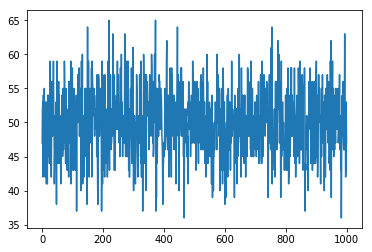

In [211]:
model = LaLSTM(bidirection=True,attention=False)
train_feature_left = np.concatenate((features_en_1,features_en_0),axis=0)
train_feature_right = np.concatenate((features_jp_1,features_jp_1),axis=0)
train_result = np.concatenate((np.ones(features_en_1.shape[0],dtype=np.float32),np.zeros(features_en_0.shape[0],dtype=np.float32)),axis=0)
train_result = train_result[:,np.newaxis]

p = np.random.permutation(len(train_result))
train_feature_left = train_feature_left[p]
train_feature_right = train_feature_right[p]
train_result = train_result[p]

print(train_feature_left.shape,train_feature_right.shape,train_result.shape)

# different optimizers
opt_SGD         = torch.optim.SGD(model.parameters(), lr=LR)
opt_Momentum    = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.8)
opt_RMSprop     = torch.optim.RMSprop(model.parameters(), lr=LR, alpha=0.9)
opt_Adam        = torch.optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.99))

criterion = torch.nn.MSELoss(size_average=False)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
optimizer = opt_Adam

all_loss = []
for epoch in range(EPOCH):
    loop = train_result.shape[0]//BATCH_SIZE
    for t in range(loop):
        # Forward pass: Compute predicted y by passing x to the model
        in_left = torch.from_numpy(train_feature_left[BATCH_SIZE*t:BATCH_SIZE*(t+1)])
        in_right = torch.from_numpy(train_feature_right[BATCH_SIZE*t:BATCH_SIZE*(t+1)])
        output = torch.from_numpy(train_result[BATCH_SIZE*t:BATCH_SIZE*(t+1)])
        y_pred = model(in_left,in_right)

        # Compute and print loss
        loss = criterion(y_pred, output)
        all_loss.append(loss.item())
        print(t, loss.item())

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
plt.plot(all_loss)

(100000, 20, 100) (100000, 20, 100) (100000, 1)
0 46.672088623046875
1 50.544559478759766
2 49.178470611572266
3 36.527462005615234
4 43.10429000854492
5 33.94477081298828
6 32.81062698364258
7 32.97272872924805
8 26.397676467895508
9 26.941328048706055
10 24.39832878112793
11 25.125732421875
12 24.968332290649414
13 24.977493286132812
14 27.479068756103516
15 26.414608001708984
16 28.40531349182129
17 29.921785354614258
18 26.100448608398438
19 26.121196746826172
20 27.561656951904297
21 26.330692291259766
22 28.189483642578125
23 25.553848266601562
24 27.54012107849121
25 26.01463508605957
26 24.284156799316406
27 25.7309513092041
28 24.843473434448242
29 25.310331344604492
30 25.183334350585938
31 25.074573516845703
32 25.39080810546875
33 25.101158142089844
34 25.032474517822266
35 25.102052688598633
36 25.679882049560547
37 26.481319427490234
38 25.47124481201172
39 25.4394474029541
40 24.268421173095703
41 24.70896339416504
42 25.006832122802734
43 24.859573364257812
44 25.240938

367 24.773258209228516
368 24.912900924682617
369 24.552078247070312
370 24.972881317138672
371 24.825225830078125
372 24.39935302734375
373 25.655418395996094
374 25.01549530029297
375 25.55006217956543
376 24.874698638916016
377 25.09866714477539
378 25.080747604370117
379 24.994802474975586
380 24.940692901611328
381 24.82843780517578
382 24.933116912841797
383 24.98972511291504
384 25.149219512939453
385 25.308170318603516
386 25.153236389160156
387 24.850984573364258
388 24.890073776245117
389 24.979446411132812
390 24.983535766601562
391 24.99533462524414
392 24.940690994262695
393 25.065185546875
394 25.030038833618164
395 25.1807918548584
396 25.454660415649414
397 25.117610931396484
398 25.041807174682617
399 24.99691390991211
400 24.870595932006836
401 24.847734451293945
402 24.948686599731445
403 25.264869689941406
404 24.76439666748047
405 24.937110900878906
406 25.2635555267334
407 24.880395889282227
408 25.648059844970703
409 25.89957618713379
410 25.05889320373535
411 24

731 24.697643280029297
732 24.79530143737793
733 24.634719848632812
734 24.741947174072266
735 24.79644203186035
736 25.032882690429688
737 24.433748245239258
738 24.352243423461914
739 24.94411277770996
740 24.777076721191406
741 25.66018295288086
742 25.484357833862305
743 25.14337730407715
744 25.05108642578125
745 24.492013931274414
746 24.805889129638672
747 25.043855667114258
748 24.8316707611084
749 24.79137420654297
750 24.676551818847656
751 24.668933868408203
752 25.032108306884766
753 24.73086166381836
754 25.000120162963867
755 24.638978958129883
756 24.876697540283203
757 24.8726863861084
758 24.970483779907227
759 24.800655364990234
760 24.824153900146484
761 25.081350326538086
762 24.715503692626953
763 24.99814224243164
764 24.76669692993164
765 24.85325813293457
766 25.203386306762695
767 24.890846252441406
768 24.93869400024414
769 25.091846466064453
770 24.713077545166016
771 25.1055908203125
772 25.076847076416016
773 25.24799919128418
774 25.175670623779297
775 24.

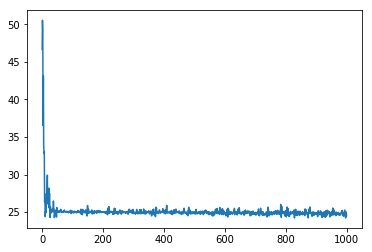

In [212]:
model_att = LaLSTM(bidirection=False,attention=True)
print(train_feature_left.shape,train_feature_right.shape,train_result.shape)

criterion = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.SGD(model_att.parameters(), lr=1e-4, momentum=0.9)

all_loss = []
for epoch in range(EPOCH):
    loop = train_result.shape[0]//BATCH_SIZE
    for t in range(loop):
        # Forward pass: Compute predicted y by passing x to the model
        in_left = torch.from_numpy(train_feature_left[BATCH_SIZE*t:BATCH_SIZE*(t+1)])
        in_right = torch.from_numpy(train_feature_right[BATCH_SIZE*t:BATCH_SIZE*(t+1)])
        output = torch.from_numpy(train_result[BATCH_SIZE*t:BATCH_SIZE*(t+1)])
        y_pred = model_att(in_left,in_right)

        # Compute and print loss
        loss = criterion(y_pred, output)
        all_loss.append(loss.item())
        print(t, loss.item())

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
plt.plot(all_loss)